<a href="https://colab.research.google.com/github/habebamostafa/Multimodal_Translation_project/blob/main/Image_to_text_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Libraries
**This cell includes the import of necessary libraries for data management, visualization, and machine learning modeling.**

In [ ]:
# Default libraries, packages for data management, visualization and Computer vision libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn package -> function
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D,
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

# Functions for Image Processing and Model Callbacks

In [ ]:
def directory_to_df(path: str):
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'  # Include both lowercase, uppercase, and numbers
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path, img_path)
            df.append([direct, cls_name])

    df = pd.DataFrame(df, columns=['image', 'label'])
    print("The number of samples found:", len(df))
    return df.copy()

def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()

def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.h5',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

**Defining Hyperparameters for Model Training**

In [ ]:
# Pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.0001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 20

# Loading the Dataset into a DataFrame

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d harieh/ocr-dataset

Dataset URL: https://www.kaggle.com/datasets/harieh/ocr-dataset
License(s): CC0-1.0
 96% 147M/153M [00:04<00:00, 43.7MB/s]
100% 153M/153M [00:04<00:00, 34.3MB/s]


In [ ]:
!unzip ocr-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/y_L/Y_L_2535.png  
  inflating: dataset/y_L/Y_L_2536.png  
  inflating: dataset/y_L/Y_L_2537.png  
  inflating: dataset/y_L/Y_L_2538.png  
  inflating: dataset/y_L/Y_L_2539.png  
  inflating: dataset/y_L/Y_L_254.png  
  inflating: dataset/y_L/Y_L_2540.png  
  inflating: dataset/y_L/Y_L_2541.png  
  inflating: dataset/y_L/Y_L_2542.png  
  inflating: dataset/y_L/Y_L_2543.png  
  inflating: dataset/y_L/Y_L_2544.png  
  inflating: dataset/y_L/Y_L_2545.png  
  inflating: dataset/y_L/Y_L_2546.png  
  inflating: dataset/y_L/Y_L_2547.png  
  inflating: dataset/y_L/Y_L_2548.png  
  inflating: dataset/y_L/Y_L_2549.png  
  inflating: dataset/y_L/Y_L_255.png  
  inflating: dataset/y_L/Y_L_2550.png  
  inflating: dataset/y_L/Y_L_2551.png  
  inflating: dataset/y_L/Y_L_2552.png  
  inflating: dataset/y_L/Y_L_2553.png  
  inflating: dataset/y_L/Y_L_2554.png  
  inflating: dataset/y_L/Y_L_2555.png  
  inflating: dataset/y_L/Y_L_25

In [ ]:
# Reading the dataset in dataframe
main_path = '/content/dataset'
df = directory_to_df(main_path)# convert the dataset into df of two columns
df.head()

The number of samples found: 210227


,image,label
0,/content/dataset/1/3403.png,1
1,/content/dataset/1/2076.png,1
2,/content/dataset/1/2044.png,1
3,/content/dataset/1/52.png,1
4,/content/dataset/1/3454.png,1


In [ ]:
df['label'].value_counts()

,count
label,
1,3473
M,3473
N,3473
J,3473
P,3473
...,...
w,3275
j,3274
c,3274


In [ ]:
df['label'].unique().sum()

'1MNJPmhBSrFepEiazgn4vTAGICycwjXOYUtKRL6Qb0u5Z37flqdDxHV9skW2o8'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210227 entries, 0 to 210226
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   image   210227 non-null  object
 1   label   210227 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


In [ ]:
df.describe()

,image,label
count,210227,210227
unique,210227,62
top,/content/dataset/8/1637.png,1
freq,1,3473


## Splitting the Dataset into Training and Testing Sets
- The dataframe is splitted to get 70% of the dataset for `training` , and 30% for `testing`
- The training set is splitted into `training` and `validation` to enhance the model training

In [ ]:
# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [ ]:
# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

# Creating Image Data Generators for Training and Testing
- The `ImageDataGenerators` is used for data augmentation, the augmentation is required since the `OCR` can work with different brightness which is not included in the dataset.
- Also, it enhance the RAM usage.

In [ ]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE,target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE,target_size=IMG_SHAPE, shuffle=False)

Found 110368 validated image filenames belonging to 62 classes.
Found 36790 validated image filenames belonging to 62 classes.
Found 63069 validated image filenames belonging to 62 classes.


**Mapping Class Indices for Later Processing**

In [ ]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

**Displaying a Sample Image from the Training Set**

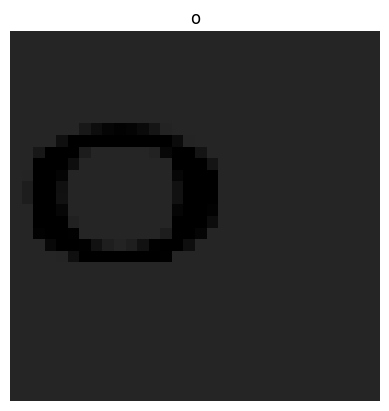

The shape of the image: (32, 32, 3)


In [ ]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 31      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

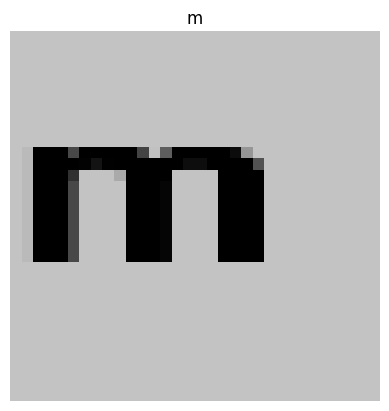

The shape of the image: (32, 32, 3)


In [ ]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 15      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

# Building a Custom Convolutional Neural Network (CNN)
*Our target is to build a **`custom CNN model`** to train on our targeted images for the `OCR` application

In [ ]:
num_classes = 62 # numbers, upper and lower letters

In [ ]:
# Custom CNN
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(num_classes, activation='softmax'))

In [ ]:
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [ ]:
import torch
print("GPU Available: ", torch.cuda.is_available())

GPU Available:  True


# Defining a Custom Callback for Image Display During Training

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


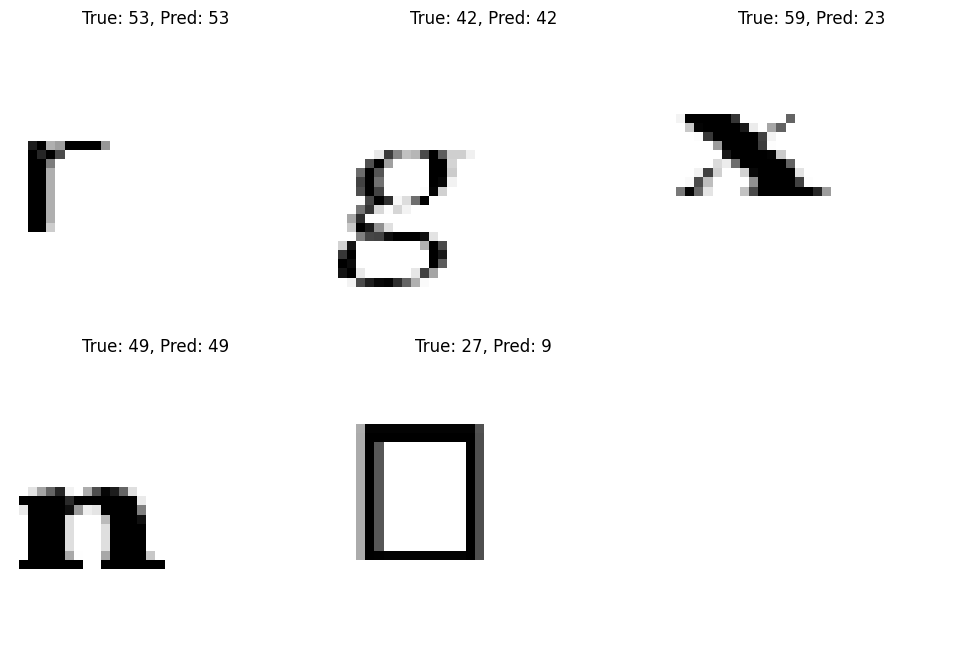

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 89s 24ms/step - accuracy: 0.4355 - loss: 2.2438 - val_accuracy: 0.8173 - val_loss: 0.7227
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


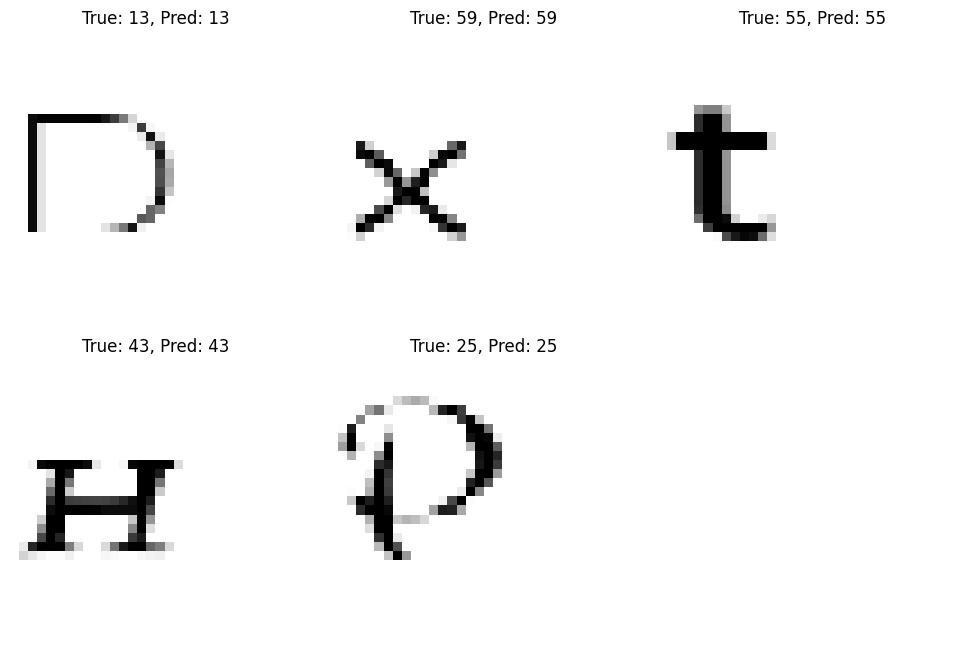

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 139s 24ms/step - accuracy: 0.8005 - loss: 0.7307 - val_accuracy: 0.8418 - val_loss: 0.5980
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


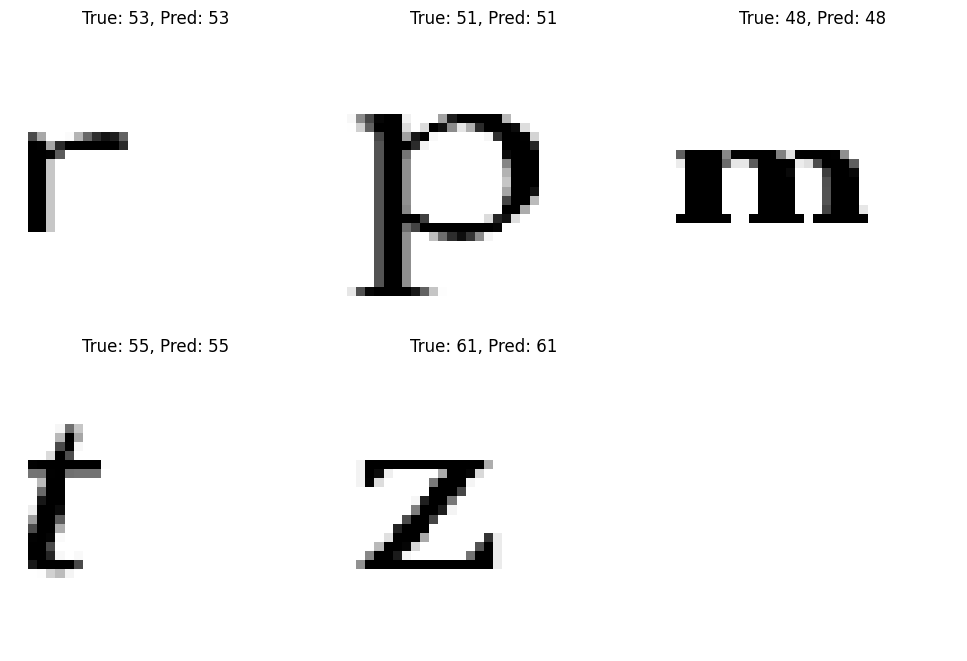

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 143s 25ms/step - accuracy: 0.8094 - loss: 0.7015 - val_accuracy: 0.8085 - val_loss: 0.7532
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


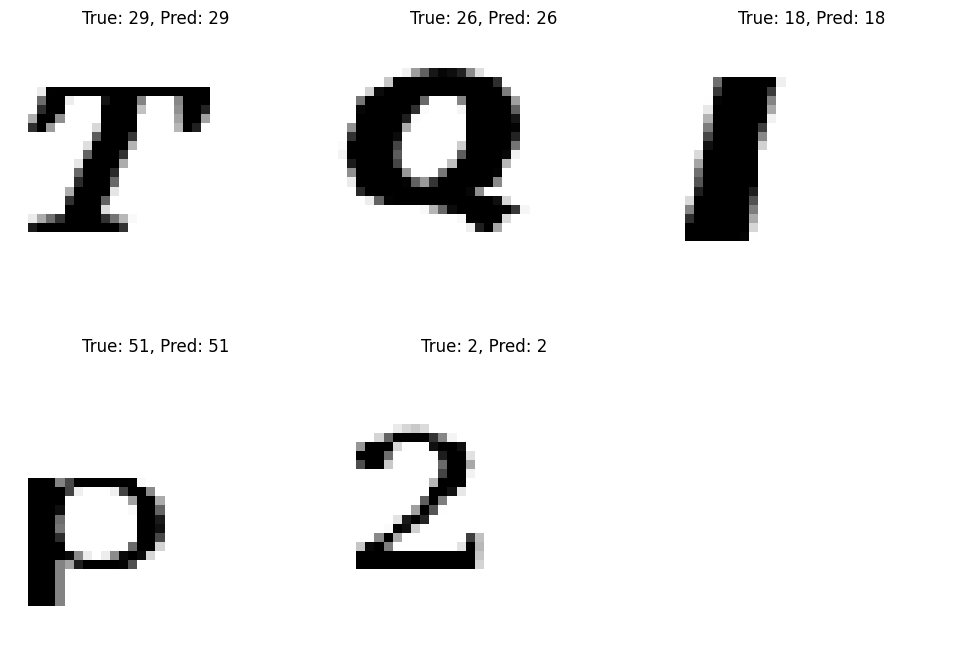

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 152s 27ms/step - accuracy: 0.8151 - loss: 0.6807 - val_accuracy: 0.8433 - val_loss: 0.5878
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


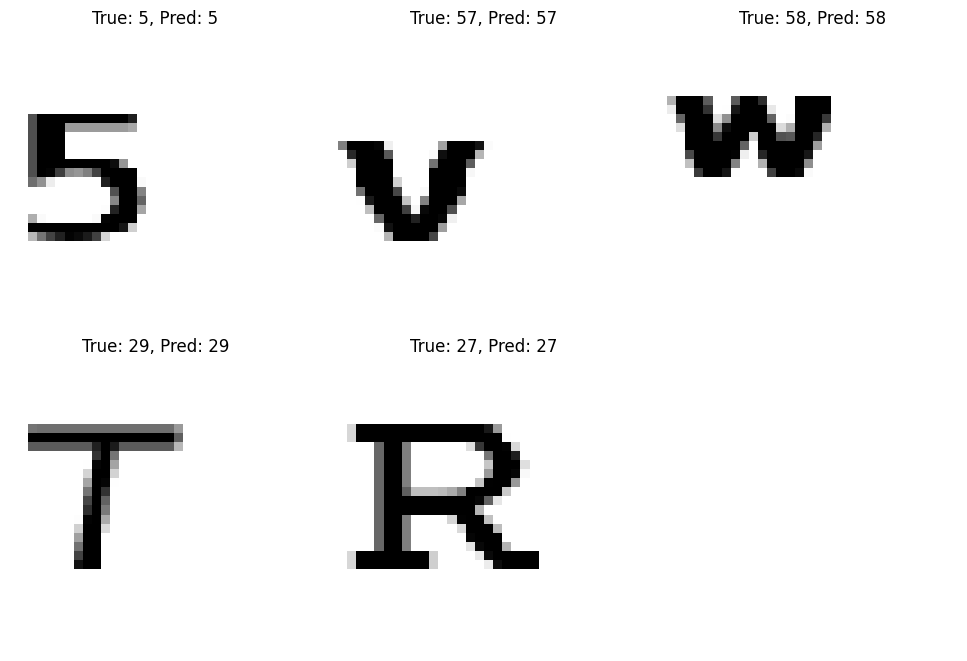

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 133s 25ms/step - accuracy: 0.8266 - loss: 0.6248 - val_accuracy: 0.6736 - val_loss: 1.3685
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


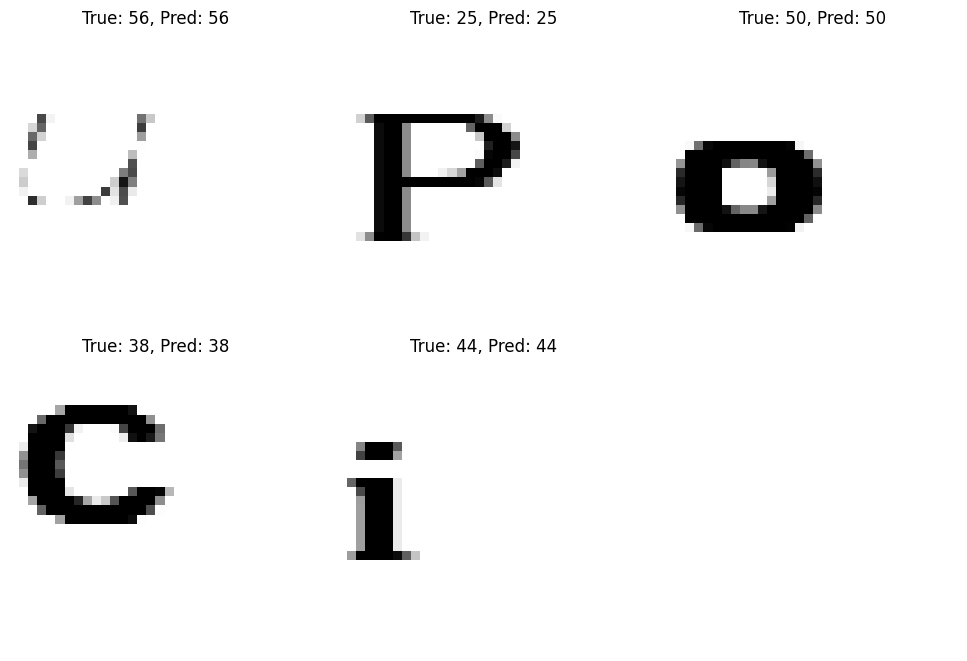

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 86s 25ms/step - accuracy: 0.7830 - loss: 0.8254 - val_accuracy: 0.8512 - val_loss: 0.5401
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


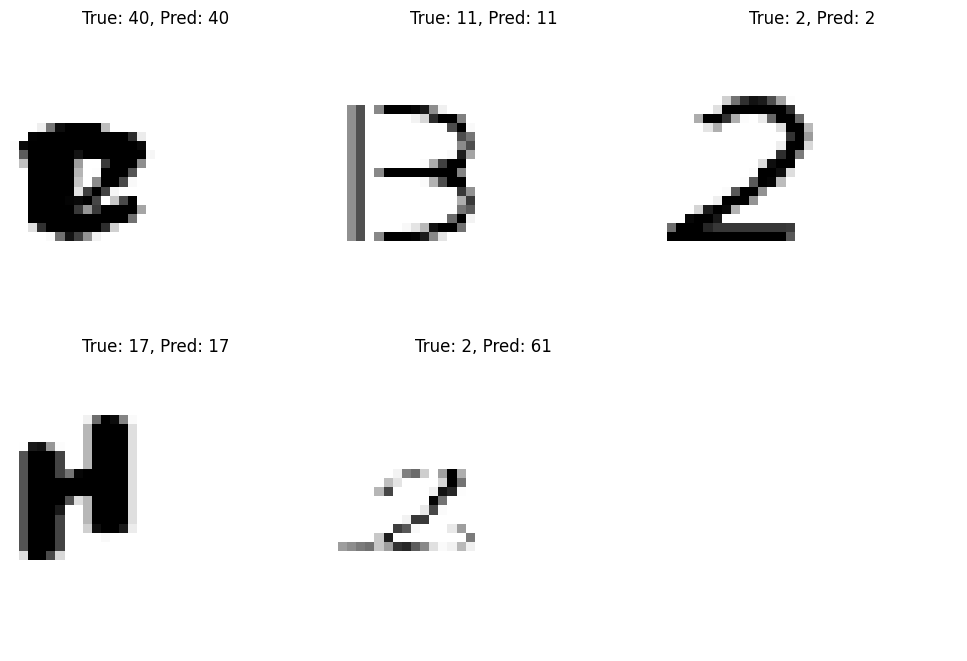

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 142s 25ms/step - accuracy: 0.8399 - loss: 0.5772 - val_accuracy: 0.8449 - val_loss: 0.5609
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


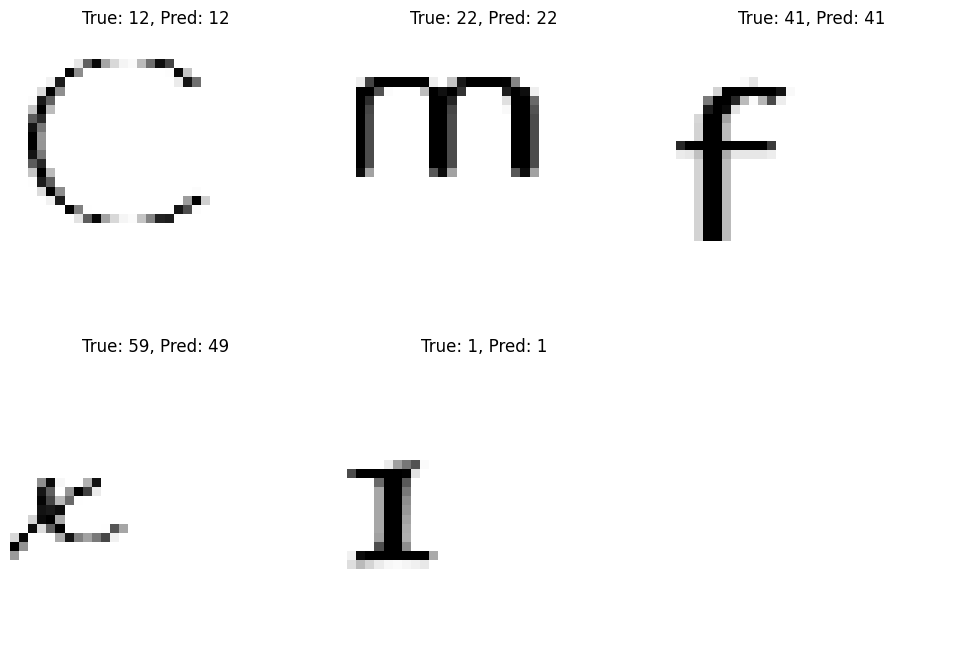

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 97s 28ms/step - accuracy: 0.8199 - loss: 0.6768 - val_accuracy: 0.8397 - val_loss: 0.6115
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


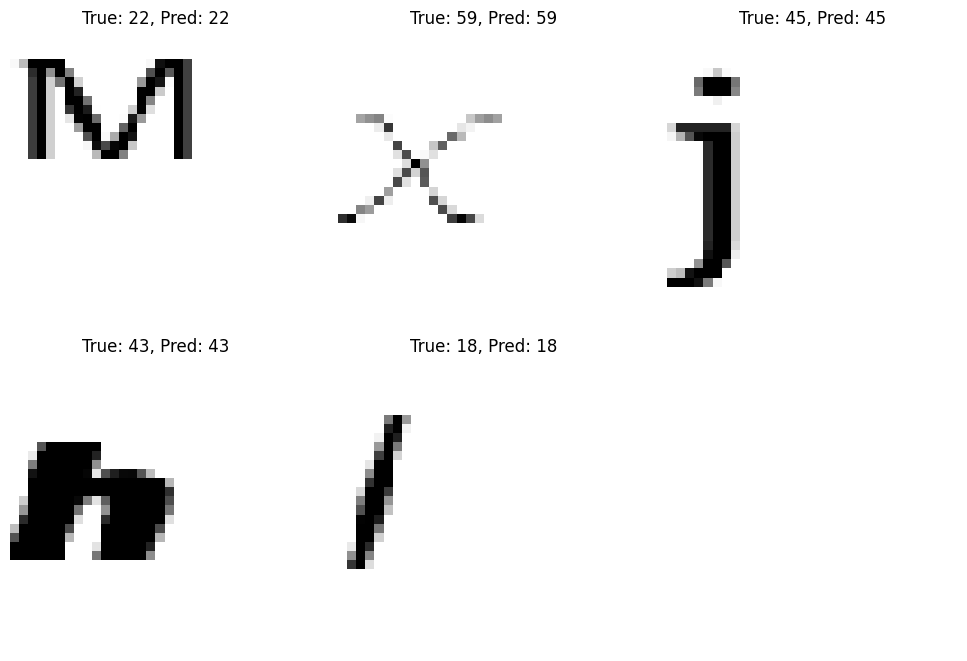

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 133s 25ms/step - accuracy: 0.8413 - loss: 0.5786 - val_accuracy: 0.8475 - val_loss: 0.5686
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


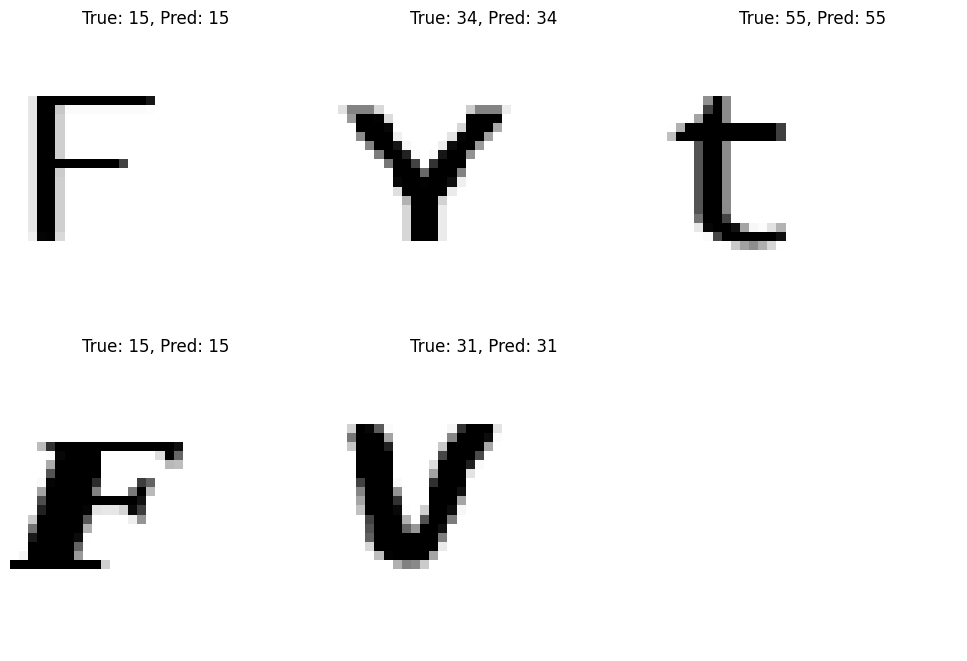

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 93s 27ms/step - accuracy: 0.8262 - loss: 0.6381 - val_accuracy: 0.8518 - val_loss: 0.5641
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


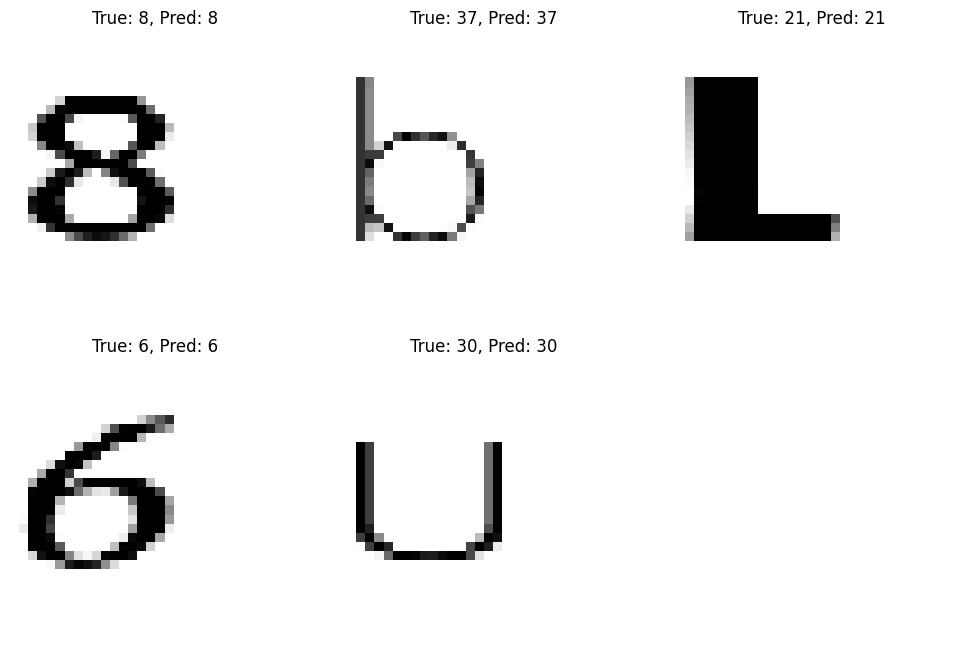

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 152s 30ms/step - accuracy: 0.8438 - loss: 0.5636 - val_accuracy: 0.8508 - val_loss: 0.5754
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


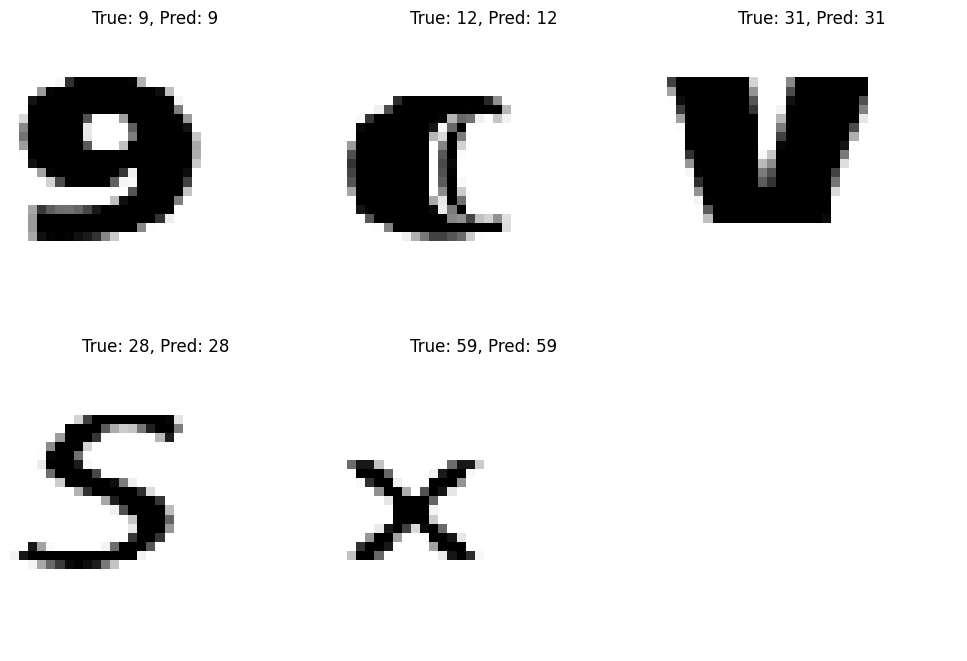

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 130s 26ms/step - accuracy: 0.8186 - loss: 0.6840 - val_accuracy: 0.8159 - val_loss: 0.8025
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


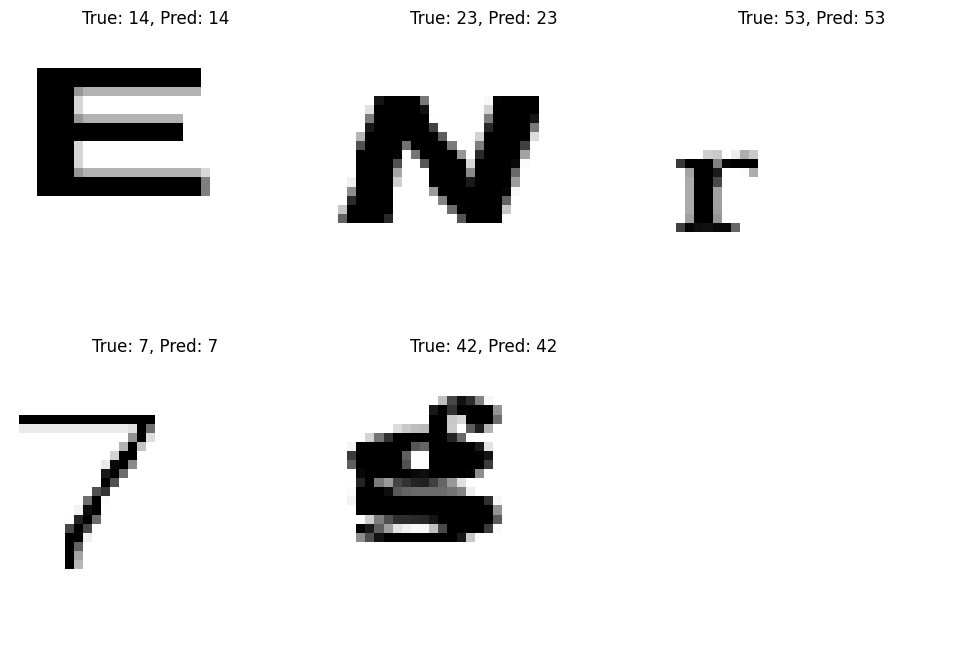

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 147s 28ms/step - accuracy: 0.8239 - loss: 0.6589 - val_accuracy: 0.8520 - val_loss: 0.5625
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


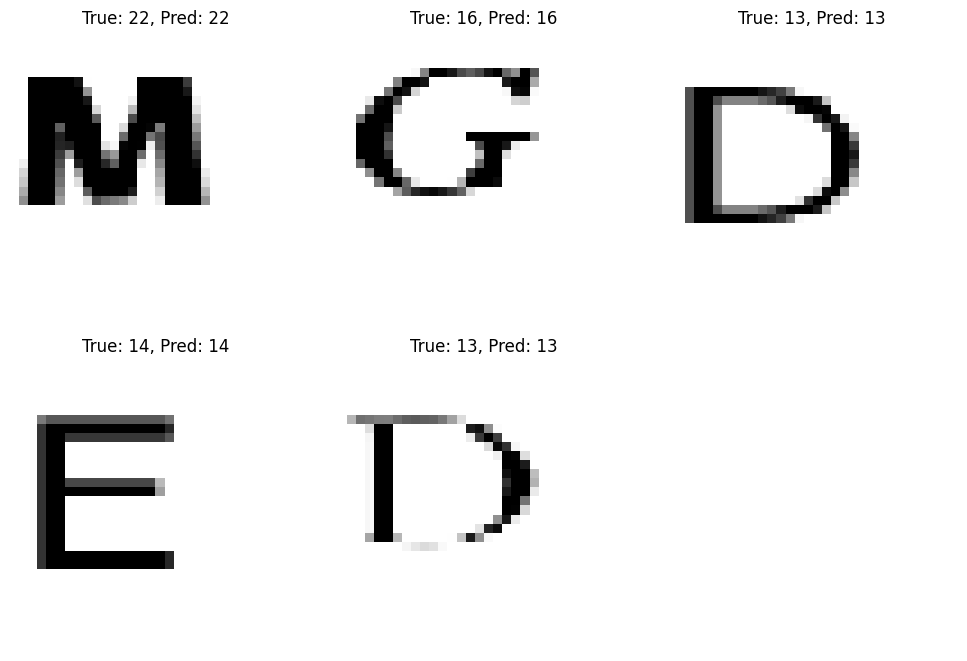

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 97s 28ms/step - accuracy: 0.8485 - loss: 0.5454 - val_accuracy: 0.7587 - val_loss: 0.9452
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


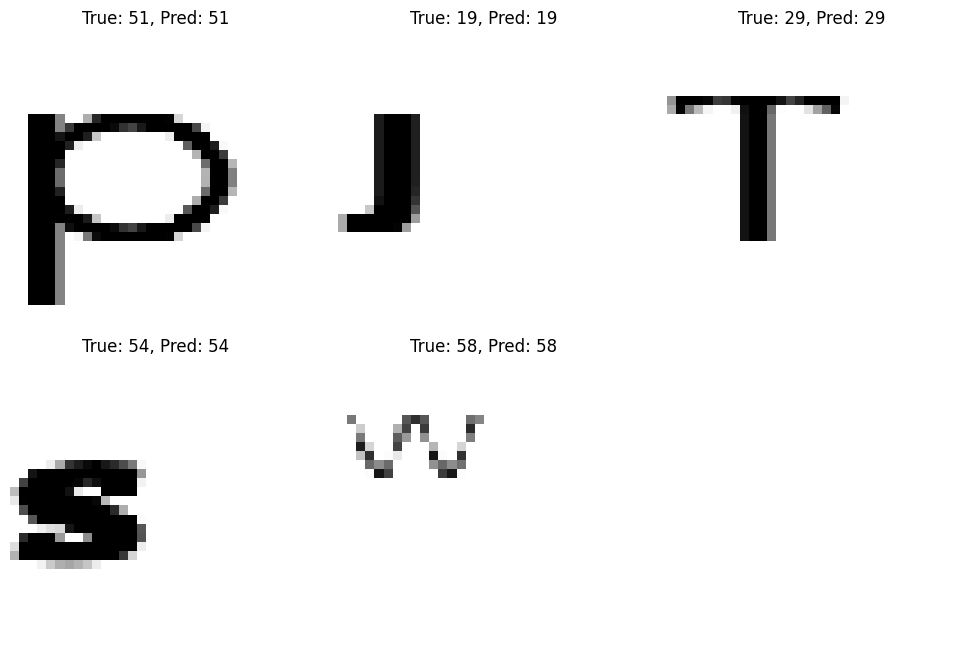

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 143s 29ms/step - accuracy: 0.8203 - loss: 0.6866 - val_accuracy: 0.8558 - val_loss: 0.5518
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


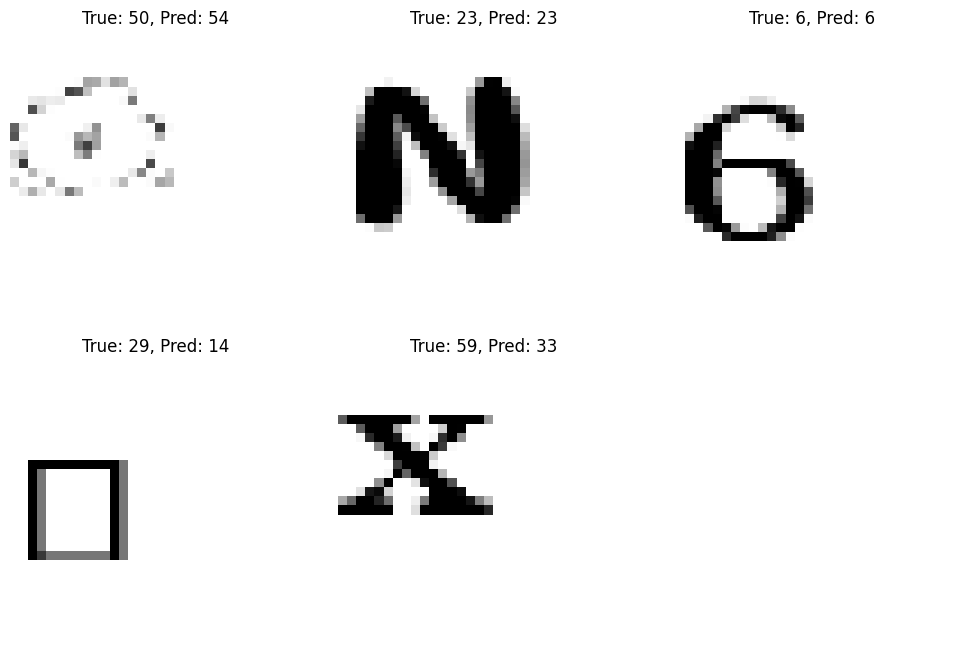

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 133s 26ms/step - accuracy: 0.8510 - loss: 0.5400 - val_accuracy: 0.7648 - val_loss: 0.9690
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


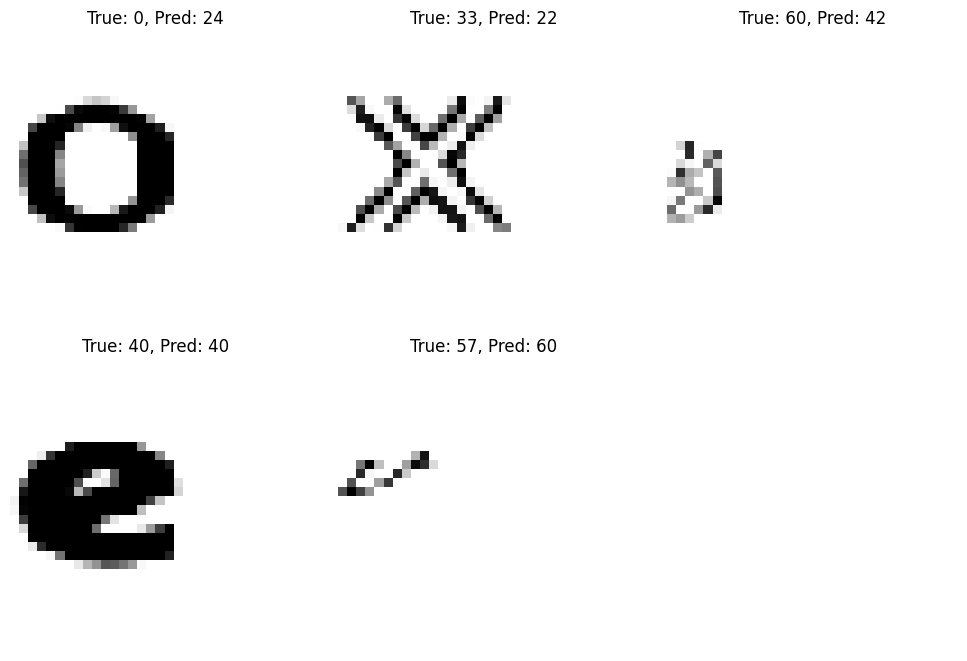

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 89s 26ms/step - accuracy: 0.8356 - loss: 0.6135 - val_accuracy: 0.8546 - val_loss: 0.5817
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


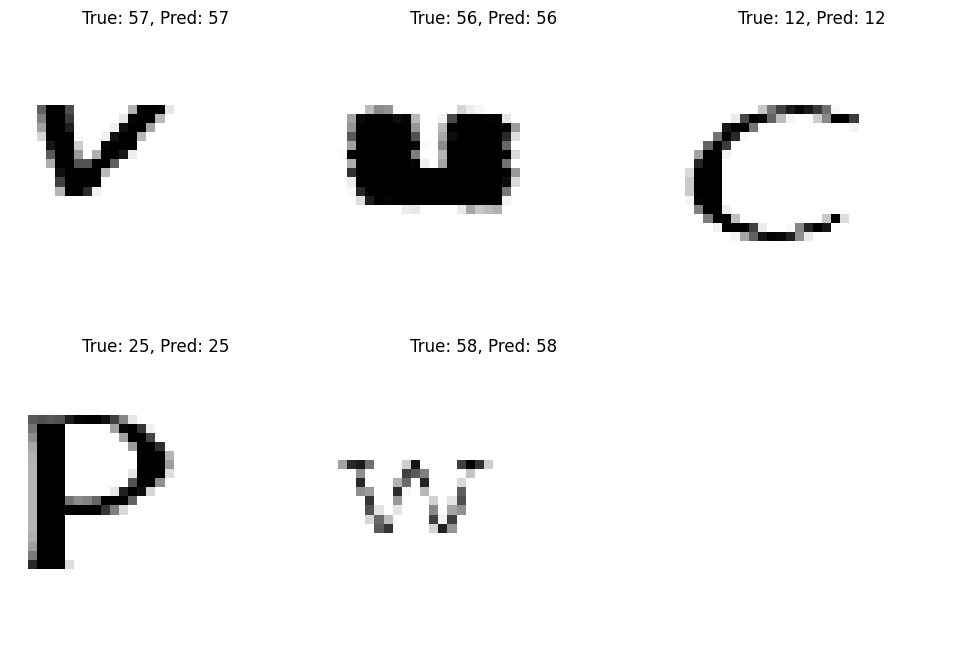

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 150s 28ms/step - accuracy: 0.8418 - loss: 0.5887 - val_accuracy: 0.8562 - val_loss: 0.5906
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


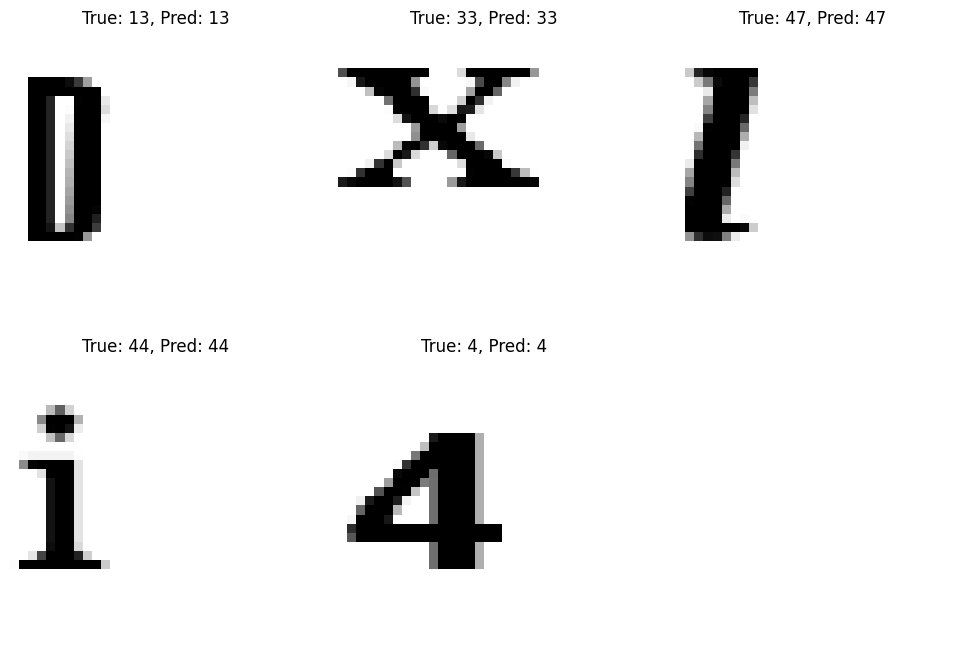

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 141s 28ms/step - accuracy: 0.8495 - loss: 0.5443 - val_accuracy: 0.8588 - val_loss: 0.5381
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


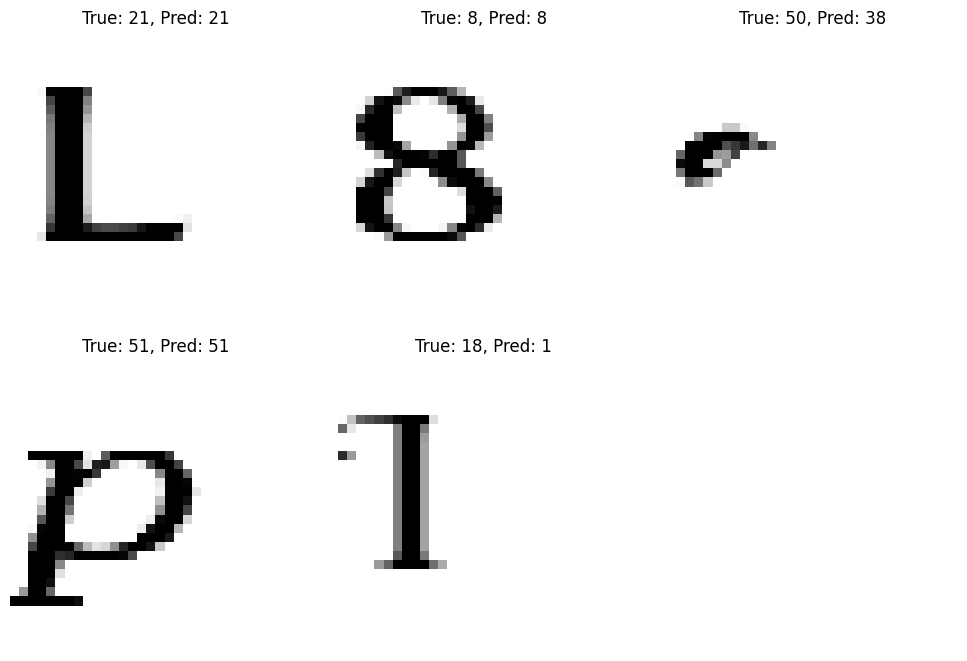

3449/3449 ━━━━━━━━━━━━━━━━━━━━ 135s 26ms/step - accuracy: 0.5405 - loss: 1.8841 - val_accuracy: 0.8432 - val_loss: 0.6128


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

class CustomImageDisplayCallback(Callback):
    def __init__(self, validation_data, model, num_images=5):
        super().__init__()
        self.validation_data = validation_data
        self._model = model  # Ensure consistency here
        self.num_images = num_images

    def on_epoch_end(self, epoch, logs=None):
        # Get a batch of validation data
        x_val, y_val = next(iter(self.validation_data))

        # Predict labels for the validation images
        predictions = self._model.predict(x_val)

        # Convert predictions and true labels to class indices (if one-hot encoded)
        predictions = np.argmax(predictions, axis=1)
        y_val = np.argmax(y_val, axis=1)

        # Display the first few validation images and their predicted labels
        plt.figure(figsize=(10, 10))
        for i in range(self.num_images):  # Limit to 'num_images'
            plt.subplot(3, 3, i+1)
            plt.imshow(x_val[i].squeeze(), cmap='gray')  # Adjust for grayscale
            plt.title(f"True: {y_val[i]}, Pred: {predictions[i]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Create the custom callback with a limited number of images to display
image_display_callback = CustomImageDisplayCallback(validation_data=valid_gen, model=CNN_model, num_images=5)

# Fit the model with the callback
history = CNN_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[image_display_callback])

# Plotting Training and Validation Loss

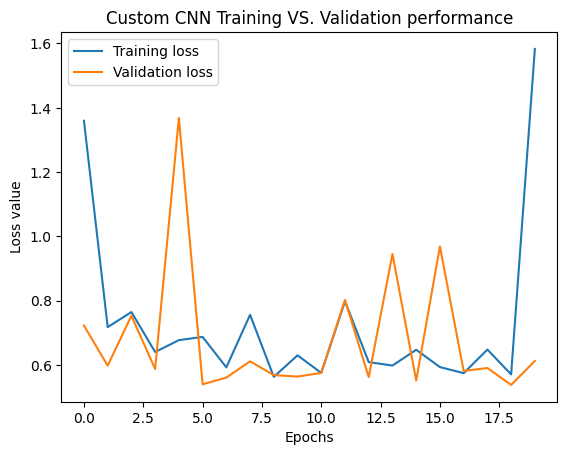

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training VS. Validation performance")
plt.show()

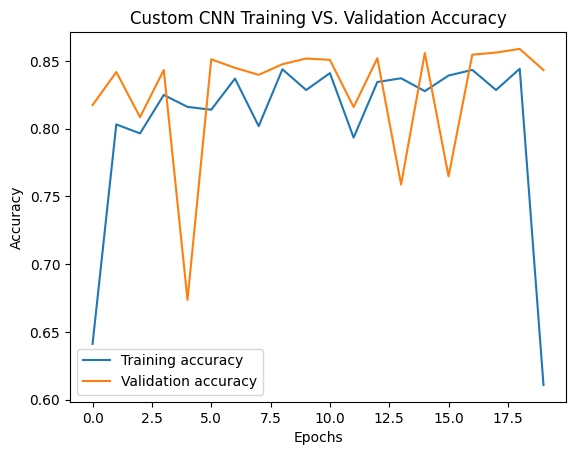

In [ ]:
# Plot training vs. validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Custom CNN Training VS. Validation Accuracy")
plt.show()

# Making Predictions on the Testing Set Using the Custom CNN

In [ ]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1971/1971 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step


In [ ]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

In [ ]:
CNN_model.save("final_model.h5")

In [ ]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': pred})
results_df.to_csv('results.csv', index=False)

In [ ]:
from IPython.display import FileLink
FileLink('results.csv')

/content/results.csv

# Post-Processing
#### **THIS SECTION IS ABOUT `Computer Vision` TECHNIQUES**

*the image will be taken from the user/externally to be processed and input into our model. some **LOW LEVEL COMPUTER VISION TECHNIQUES** are used in order to enhance the input image, wheter it is text or handwritten, these techniques are the following:*

- **Binarization:** The binarization function applies Otsu's binarization to the grayscale image, producing a binary image.

- **Dilate:** The dilate function performs morphological dilation on the binary image. The degree of dilation is adjusted based on whether processing `words` or `characters`.

- **Find Rectangles:** The find_rect function identifies bounding rectangles in the binary image, sorting them based on their **x-coordinate (From Left-to-Right)**.

- **Extract Characters:** The extract function uses the aforementioned techniques to extract characters from the image. It identifies words **FIRST**, then extracts characters from each word, and with the use of the pre-trained deep learning model to recognize each character.

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt  # For visualization

def load_model():
    model_path = '/content/Model/cnn_model.h5'
    model = tf.keras.models.load_model(model_path)
    return model

def convert_2_gray(image):
    # Convert RGB to grayscale if necessary
    if len(image.shape) == 3 and image.shape[2] == 3:  # Color image (RGB)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image  # Already grayscale
    return gray_image

def binarization(image):
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    return thresh

def dilate(image, words=False):
    img = image.copy()
    m = 3
    n = m - 2  # Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations=itrs)
    return dilation

def find_rect(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        rects.append([x, y, w, h])
    sorted_rects = sorted(rects, key=lambda x: x[0])  # Sort rects left to right
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []  # A list to store recognized characters

    # Convert to grayscale if in color
    image_cpy = convert_2_gray(image)

    # Binarization and dilation for word detection
    bin_img = binarization(image_cpy)
    full_dil_img = dilate(bin_img, words=True)
    words = find_rect(full_dil_img)  # Detect words based on dilated image

    prev_x_end = 0  # To track the end of the previous word's bounding box

    for word in words:
        x, y, w, h = word  # Coordinates of the word
        img = image_cpy[y:y + h, x:x + w]  # Crop the word

        # Add a space if the distance between the current word and previous word exceeds a threshold
        if x - prev_x_end > 20:  # Adjust the threshold value based on spacing between words
            chars.append(' ')

        # Update previous word's ending X coordinate
        prev_x_end = x + w

        # Draw rectangle around word (for visualization)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Binarize and dilate to find characters
        bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)  # Detect characters within the word

        for char in char_parts:
            cx, cy, cw, ch = char
            ch_img = img[cy:cy + ch, cx:cx + cw]  # Crop character

            # Resize character image to fit model input (32x32)
            empty_img = np.full((32, 32, 1), 255, dtype=np.uint8)
            resized = cv2.resize(ch_img, (16, 22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[3:3 + 22, 3:3 + 16, 0] = gray  # Place resized character in the center

            # Convert grayscale image to RGB for the model
            gray_rgb = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray_rgb = gray_rgb.astype(np.float32) / 255.0  # Normalize image

            # Predict the character
            prediction = model.predict(np.array([gray_rgb]), verbose=0)
            predicted_char = mapping_inverse[np.argmax(prediction)]
            chars.append(predicted_char)  # Add the recognized character to the list

    # Visualize the image with detected words
    show_image(image)

    return ''.join(chars)  # Join characters and include spaces

def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.axis('off')  # Hide axes
    plt.show()

In [ ]:
mapping_inverse = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't', 56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'}
print(mapping_inverse)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't', 56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'}
